In [1]:
#Download dependencies before proceeding

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from arboreto.algo import grnboost2
import os
import umap

sns.set(rc={'figure.figsize':(12,8)})
sns.set(style='whitegrid')

/home/users/jvs15/miniconda3/envs/moleculekit/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Read in time-series RNA-seq data
data_df = []
names = []
tflist = []

wd = '/home/users/jvs15/MachineLearningProstate'
#wd = '/Users/Jake/MachineLearningProstate'

for name in os.listdir(f'{wd}/data/timeseries/'):
    data_df.append(pd.read_csv(f'{wd}/data/timeseries/{name}'))
    names.append(name)
tf_df = pd.read_csv('Homo_sapiens_TF.csv')

#List of TFs
tfs = set(tf_df['Symbol'].tolist())
#Create transcription factor DF 
#Training can occur on just TFs or with all genes, depending on computational resources.
onlytfs_df = []
for i in data_df:
    x = i[i['Gene'].isin(tfs)]
    x = x.set_index('Gene')
    onlytfs_df.append(x)
    tflist.append(list(x.index))

onlytfs_df[0].head

<bound method NDFrame.head of         LNCaP_Clone07_04uM  LNCaP_Clone07_16uM  LNCaP_Clone07_50uM
Gene                                                              
ZNF676            0.000000            1.121666           11.182009
HES7              3.333545            7.851663           31.061136
ID4               0.000000            0.000000           29.818690
ZNF208            3.333545            7.851663           62.122271
NKX1-2            0.000000            0.000000            8.697118
...                    ...                 ...                 ...
E2F7            195.012360           66.178299           38.515808
E2F2            103.339883           52.718306           19.879127
BCL11B          140.842260           16.824991           26.091354
LHX9              2.500158            0.000000            0.000000
NR2F1             8.333862            7.851663            0.000000

[1190 rows x 3 columns]>

In [3]:
# Merge all data into one df for UMAP
all_data = data_df[0]
for i in range(1, len(data_df)):
    all_data = pd.merge(all_data, data_df[i], on = ['Gene'], how='inner')

# Remove rows containing genes with na values--should be none, but just in case
all_data = all_data.dropna()

# Take transpose of dataframe
all_data = all_data.T

# Make gene names into column names and remove from matrix
all_data.columns = all_data.iloc[0]
all_data = all_data.drop(['Gene'])
# Remove timeseries data from all_data
all_data = all_data.drop([x for x in list(all_data.index.values) if (len(x.split('_')) < 3)])

# Add factors to dataframe
rows = list(all_data.index)
rowtypes = [x.split('_')[1] if (len(x.split('_')) > 2) else 'timeseries' for x in rows]
doses = [x.split('_')[2] if (len(x.split('_')) > 2) else x.split('_')[1] for x in rows]
all_data_umap = all_data.copy()
all_data_umap.insert(0, 'Sample Type', rowtypes, True)
all_data_umap.insert(1, 'Doses', doses, True)

#print(all_data.head)
print(all_data_umap.head)

<bound method NDFrame.head of Gene               Sample Type Doses         LBH       HPGD     CHRDL2  \
LNCaP_Clone07_04uM     Clone07  04uM    0.833386        0.0   0.833386   
LNCaP_Clone07_16uM     Clone07  16uM         0.0   3.364998   3.364998   
LNCaP_Clone07_50uM     Clone07  50uM   14.909345   29.81869  79.516507   
LNCaP_Clone10_04uM     Clone10  04uM         0.0        0.0        0.0   
LNCaP_Clone10_16uM     Clone10  16uM         0.0        0.0   1.988285   
LNCaP_Clone10_50uM     Clone10  50uM   82.704033   4.531728  21.525707   
LNCaP_Clone03_04uM     Clone03  04uM    0.776808        0.0        0.0   
LNCaP_Clone03_16uM     Clone03  16uM    4.322279    1.08057   3.241709   
LNCaP_Clone03_50uM     Clone03  50uM    3.427525   9.140066  30.847721   
LNCaP_Clone04_04uM     Clone04  04uM    0.742849        0.0        0.0   
LNCaP_Clone04_16uM     Clone04  16uM    6.024117        0.0    3.61447   
LNCaP_Clone04_50uM     Clone04  50uM  119.985675  21.570458  25.614919   

Gene   

In [4]:
doses = [x.split('_')[2] if (len(x.split('_')) > 2) else x.split('_')[1] for x in rows]
samples = [x.split('_')[1] if (len(x.split('_')) > 2) else x.split('_')[1] for x in rows]

Reorganize data; instead of grouping by individual, group by drug concentration. Do not include timeseries data

In [16]:
new_data_df = []
dose_names = []
newtflist = []
for dose in list(set(doses)):
    x = all_data_umap.loc[all_data_umap['Doses']== dose].T
    x = x.drop(['Sample Type', 'Doses'])
    new_data_df.append(x)
    dose_names.append(dose)

# RESUME HERE--GET LIST OF TFS BASED ON DOSE INSTEAD OF INIVIDUAL
new_onlytfs_df = []
for i in new_data_df:
    x = i[i.index.isin(tfs)]
    x = x.drop(['ZNF33B']) # grnboost2 consistently fails to infer interactions for this gene; skews data, so deleting it
    new_onlytfs_df.append(x)
    newtflist.append(list(x.index))


Get UMAP working here

In [36]:
#Set up UMAP; ensemble it with 100 iterations
niter = 1
embedding = np.zeros((12, 2))

for i in range(niter):
    reducer = umap.UMAP()
    embedding += reducer.fit_transform(all_data)
embedding = np.divide(embedding, niter * np.ones(embedding.shape))

/home/users/jvs15/miniconda3/envs/moleculekit/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Text(0.5, 1.0, 'UMAP plot of each expression set')

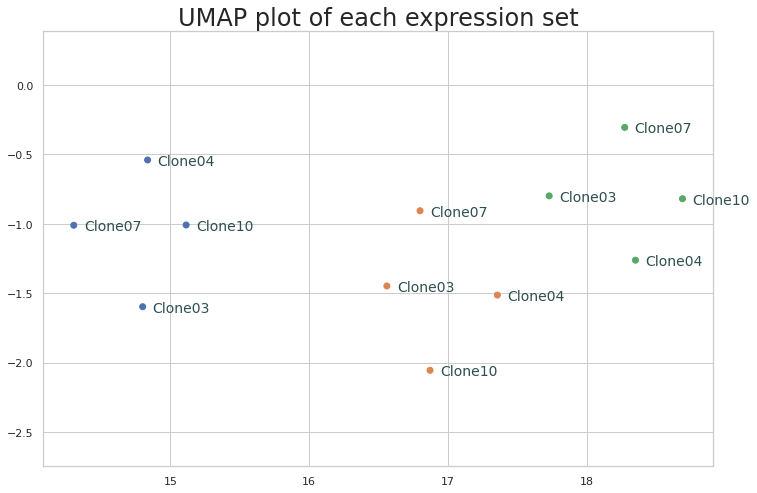

In [37]:
#Make scatter plot of UMAP

fig, ax = plt.subplots()

colors = colors = ['red','green','blue']
palette = [sns.color_palette()[x] for x in all_data_umap['Doses'].map({"04uM":0, "16uM":1, "50uM":2})]

ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=palette)
plt.gca().set_aspect('equal', 'datalim')

for i, txt in enumerate(samples):
    ax.annotate(txt, (embedding[i, 0], embedding[i, 1]), xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=14, color='darkslategrey')

plt.title('UMAP plot of each expression set', fontsize=24)

In [9]:
#Train network using GRNBoost2
network = []
ofile = []
for i in range(len(onlytfs_df)):
    x = data_df[i]
    x = x.set_index('Gene')
    network.append(grnboost2(expression_data=x.T, tf_names = tflist[i]))
    print(f"Finished training {names[i]}")
    #Network file   
    ofile.append(f'trained_network_{names[i]}')
    network[i].to_csv(ofile[i])
    print("Saved network file!")

In [17]:
#Train network using GRNBoost2 on concentration groups
network = []
ofile = []
for i in range(len(new_onlytfs_df)):
    x = new_data_df[i]
    #network.append(grnboost2(expression_data=x.T, tf_names = newtflist[i]))
    network.append(grnboost2(expression_data=new_onlytfs_df[i].T))
    print(f"Finished training {dose_names[i]}")
    #Network file   
    ofile.append(f'trained_network_{dose_names[i]}')
    network[i].to_csv(f'{ofile[i]}.csv')
    print("Saved network file!")

Finished training 16uM
Saved network file!
Finished training 50uM
Saved network file!
Finished training 04uM
Saved network file!


In [18]:
#View Network
network.clear()
for i in range(len(ofile)):
    network.append(pd.read_csv(f'{wd}/STAMPScreen/grn_centrality/{ofile[i]}.csv'))

/home/users/jvs15/miniconda3/envs/moleculekit/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/users/jvs15/miniconda3/envs/moleculekit/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/users/jvs15/miniconda3/envs/moleculekit/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

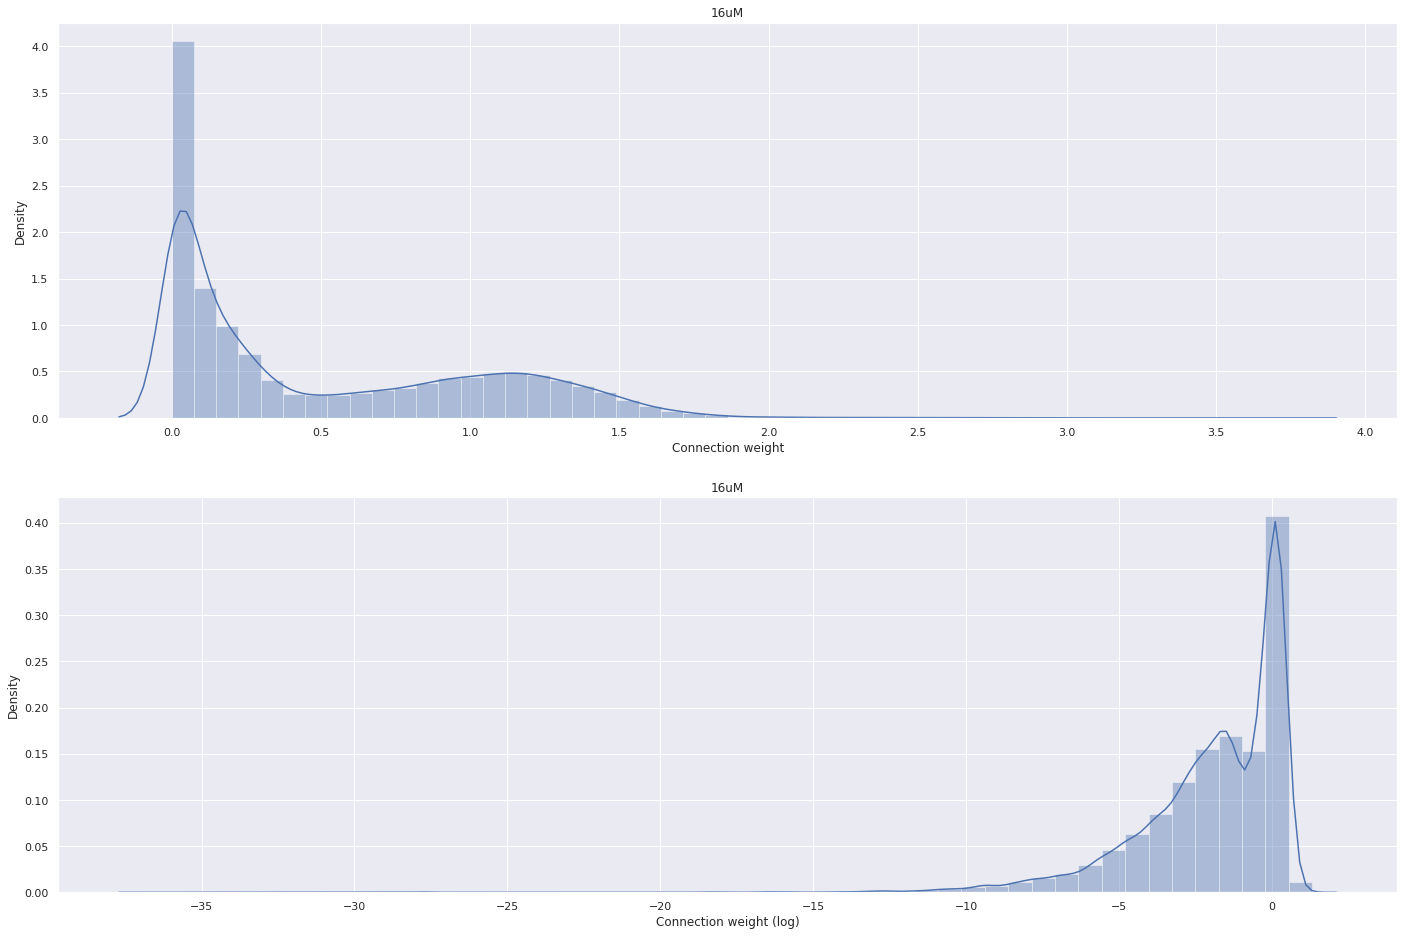

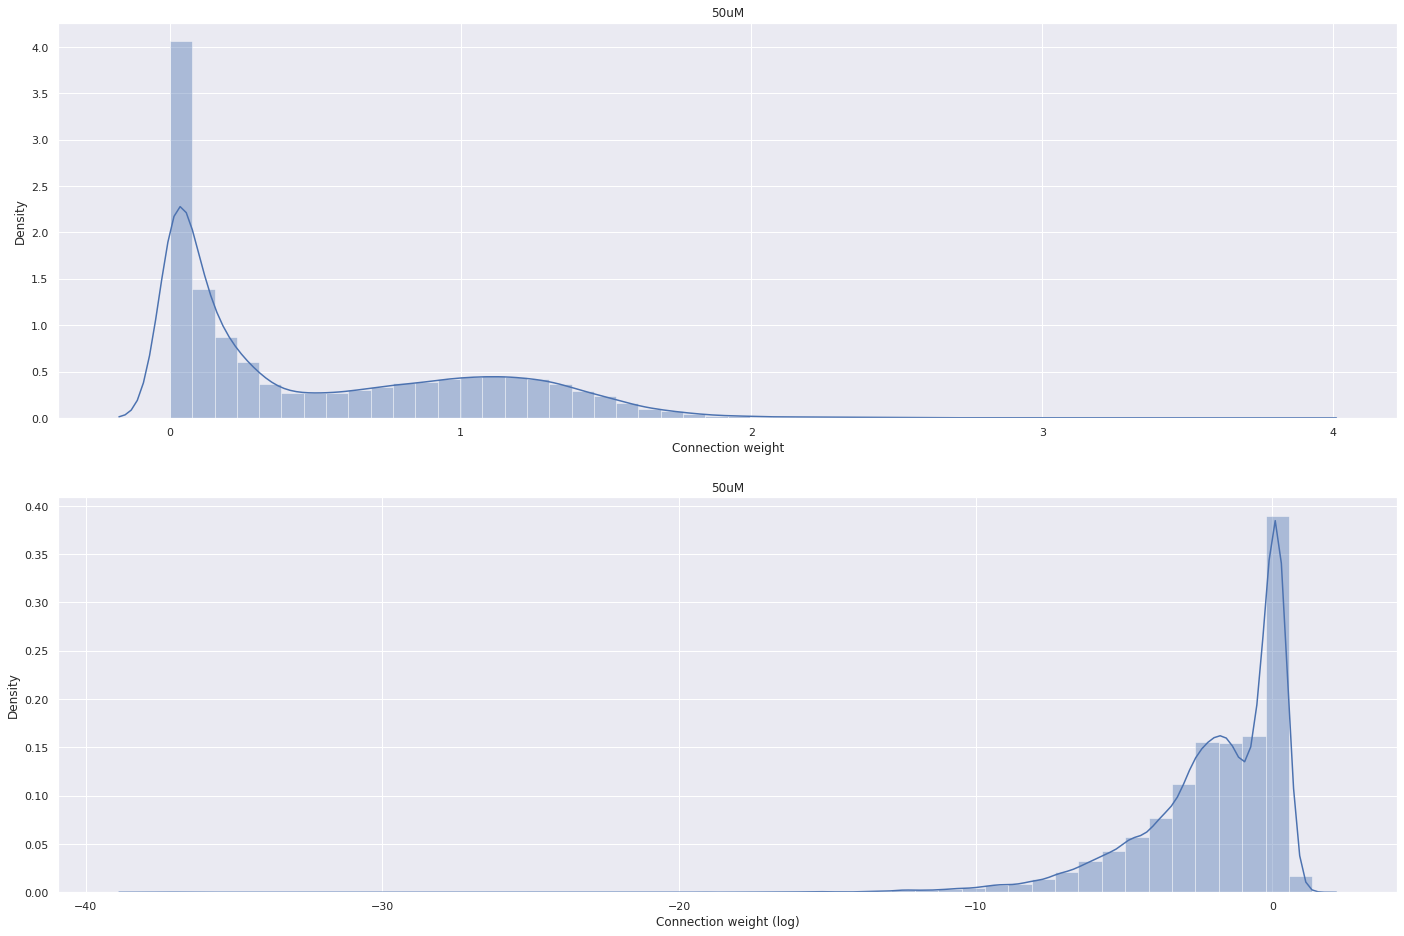

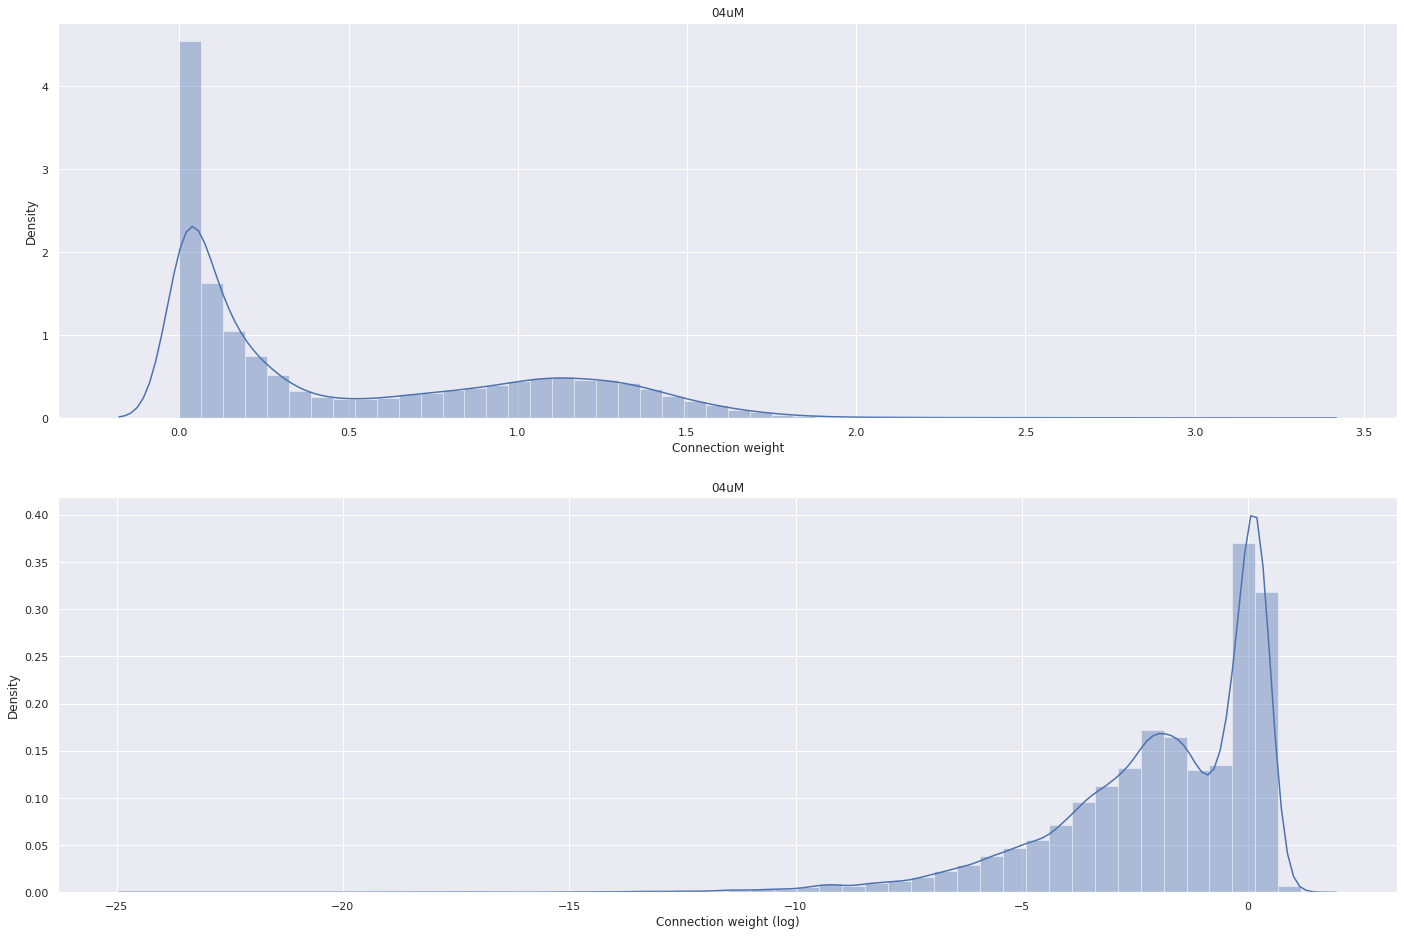

In [19]:
#Visualize edge weight distribution
for i in range(len(network)):
    f, axes = plt.subplots(2, 1)

    sns.distplot(a=network[i]['importance'], norm_hist=True, ax=axes[0]).set(title= f'{dose_names[i]}')
    sns.distplot(a=network[i]['importance'].apply(np.log), norm_hist=True, ax=axes[1]).set(title= f'{dose_names[i]}')

    axes[0].set_xlabel('Connection weight')
    axes[1].set_xlabel('Connection weight (log)')

In [20]:
#Create graph
G = [] 
for i in range(len(network)):
    G.append(nx.from_pandas_edgelist(df=network[i], source='TF', target='target', edge_attr='importance'))
    print('Loaded {:,} genes with {:,} edges.'.format(len(G[i].nodes), len(G[i].edges)))

Loaded 1,186 genes with 57,396 edges.
Loaded 1,187 genes with 64,877 edges.
Loaded 1,188 genes with 57,662 edges.


In [21]:
#Prune graph

cutoff = 1

print('Removing all edges with weight < {}...\n'.format(cutoff))

for i in range(len(G)):
    bad_edges = [(s,t,w) for (s,t,w) in G[i].edges.data('importance') if w < cutoff]
    G[i].remove_edges_from(bad_edges)
    print('Graph now has {:,} genes and {:,} edges.'.format(len(G[i].nodes), len(G[i].edges)))

Removing all edges with weight < 1...

Graph now has 1,186 genes and 13,700 edges.
Graph now has 1,187 genes and 15,199 edges.
Graph now has 1,188 genes and 14,104 edges.


In [22]:
# Run PageRank
prdf = []
for i in range(len(G)):
    pr = nx.pagerank(G[i], alpha=0.85, max_iter=50, weight='importance')
    #Create dataframe for PageRank values
    prdf.append(pd.DataFrame(pd.Series(pr)).reset_index())
    prdf[i].columns = ['Gene', 'PageRank']
    print("Finished")

Finished
Finished
Finished


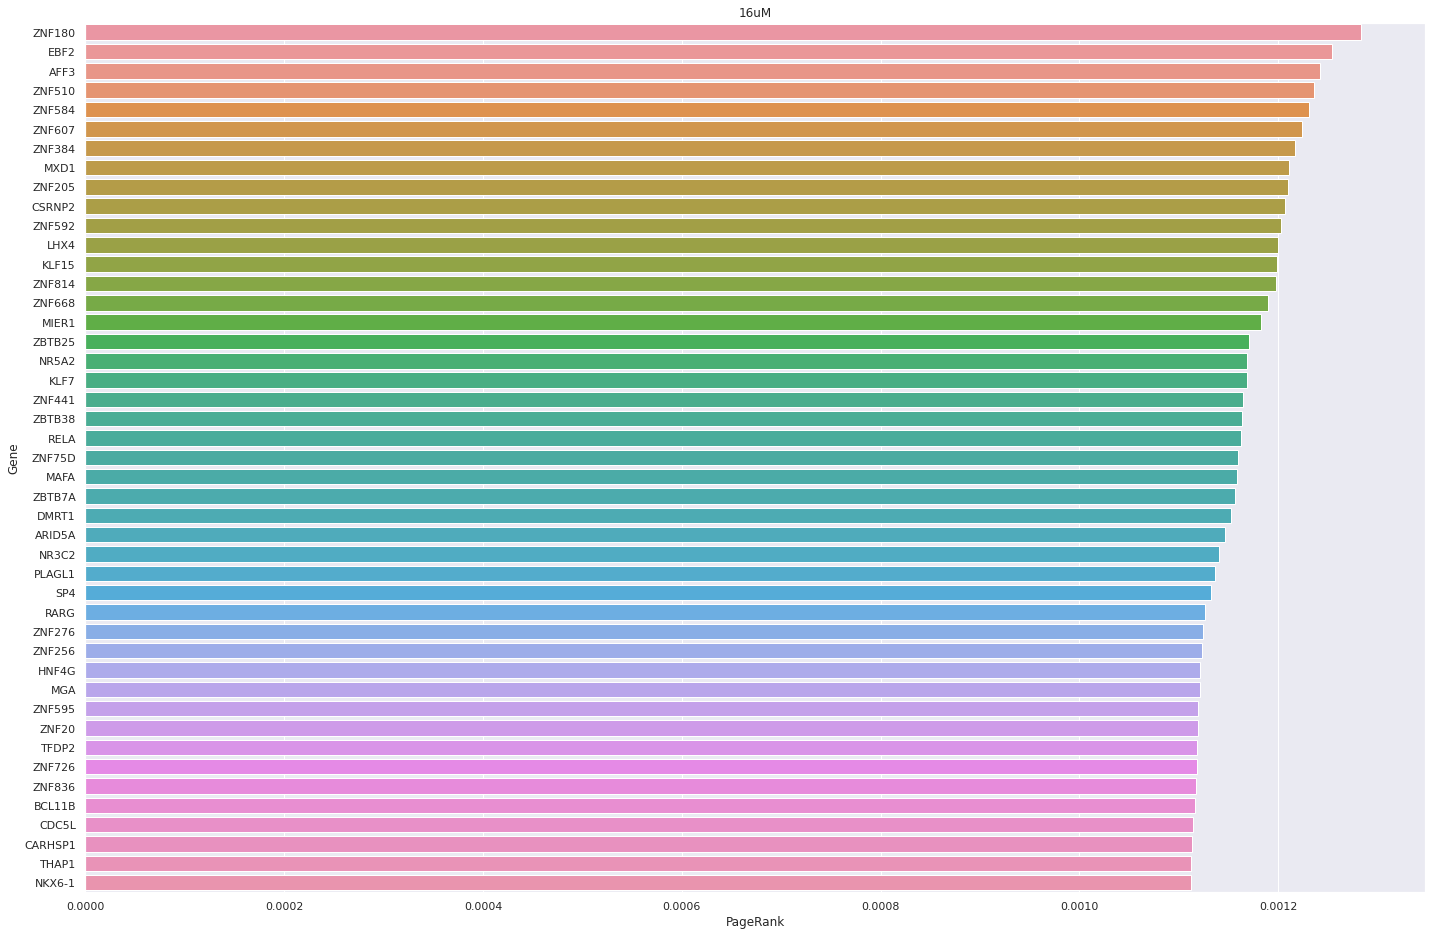

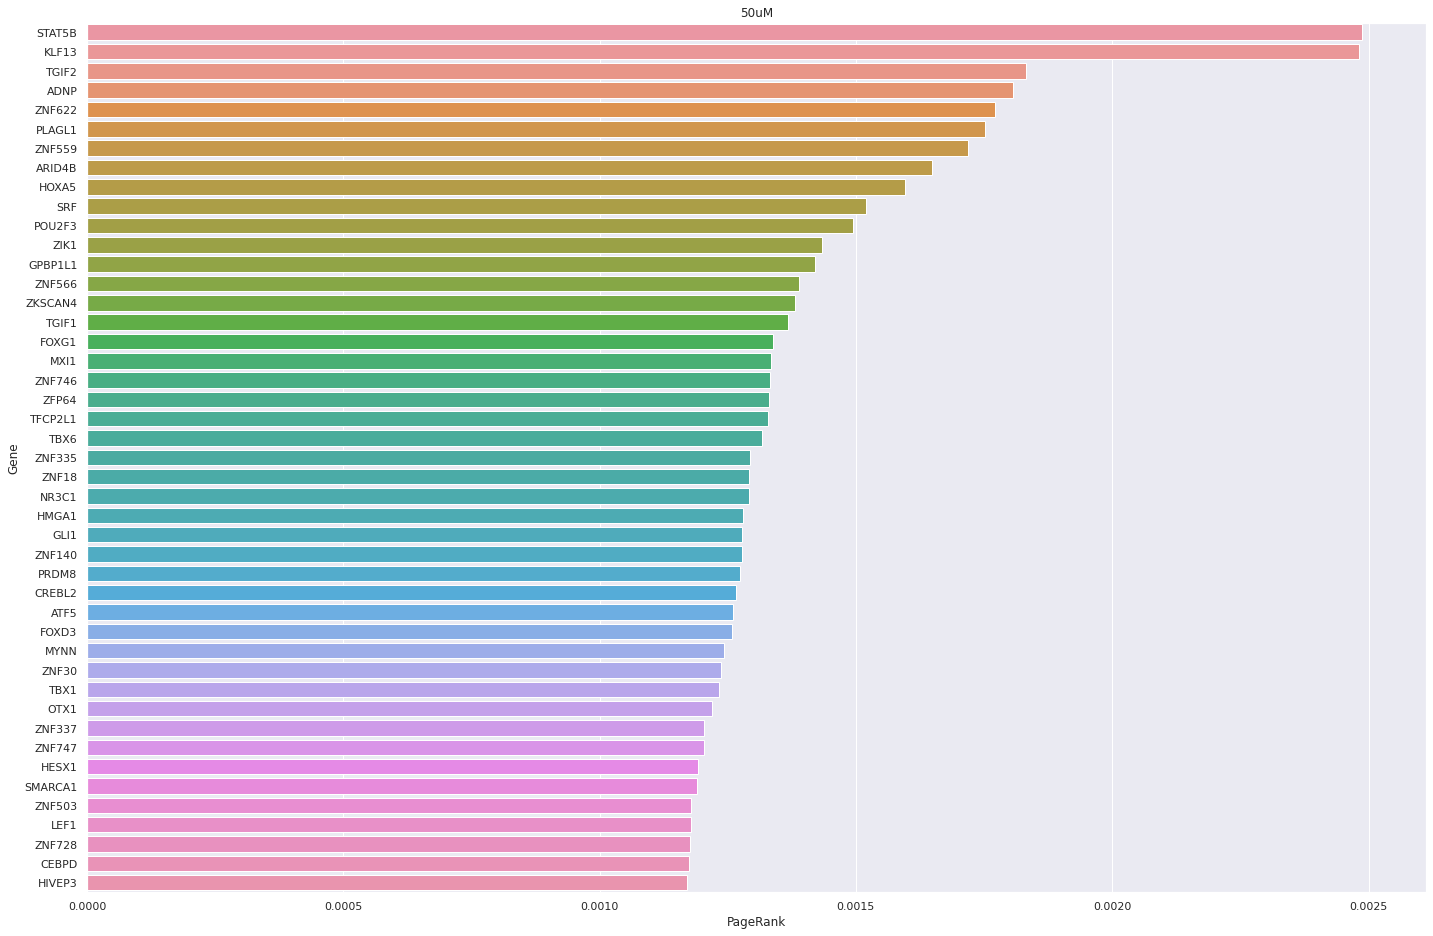

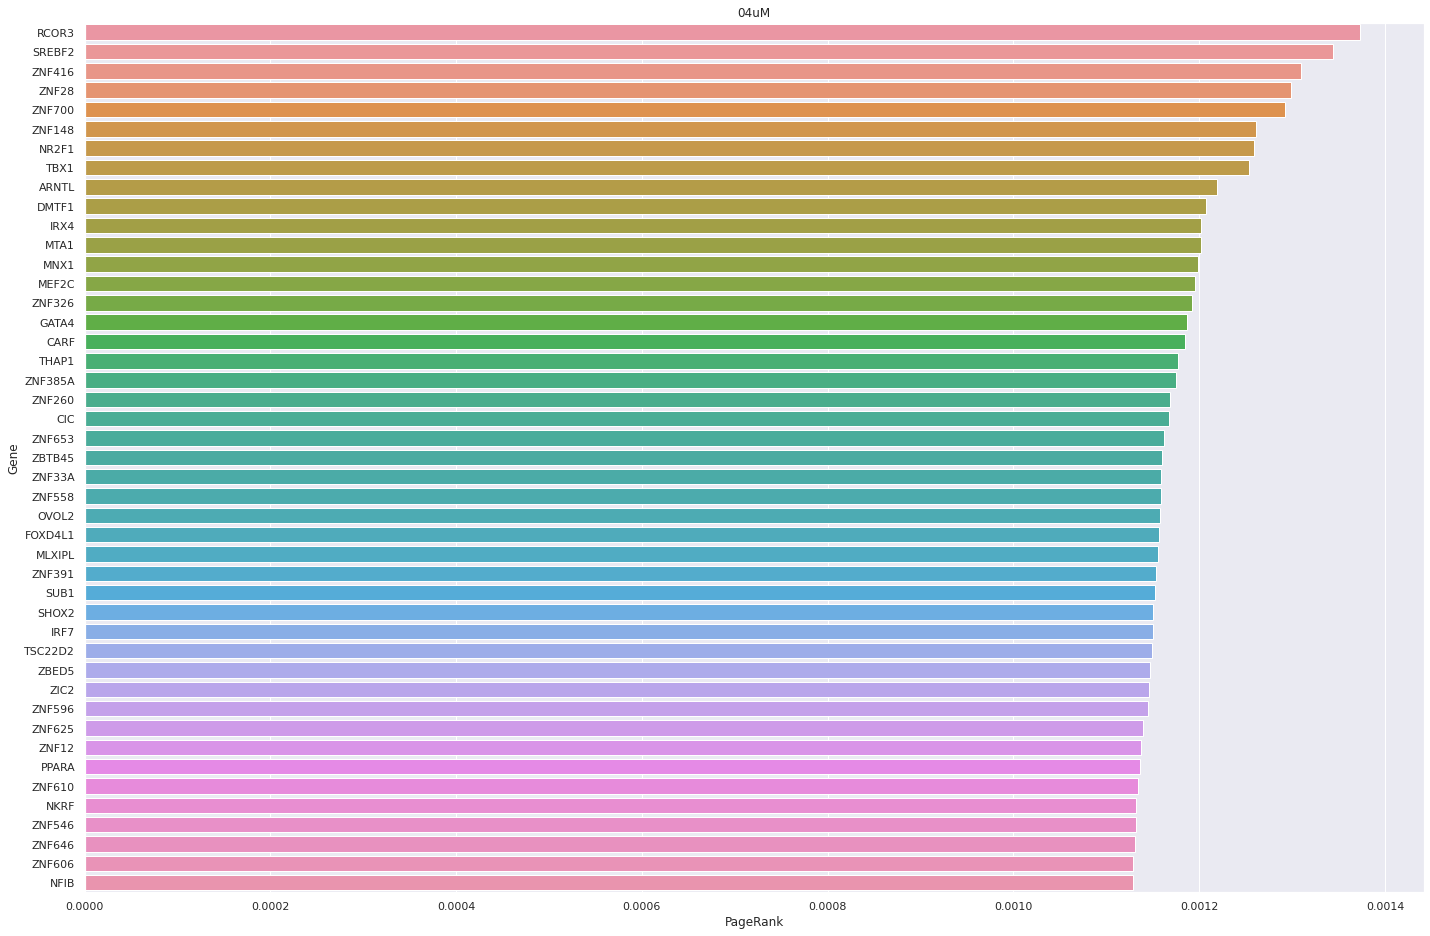

In [23]:
#View top TFs
for i in range(len(prdf)):
    sns.set(rc={'figure.figsize':(24,16)})
    sns.barplot(
        data=prdf[i].sort_values('PageRank', ascending=False).head(45), 
        x='PageRank', 
        y='Gene'
    ).set(title=f'{dose_names[i]}')
    data=prdf[i].sort_values('PageRank', ascending=False)
    #Save ranked TFs
    data.to_csv(f'{dose_names[i]}pageranked_tfs.csv')
    plt.show()

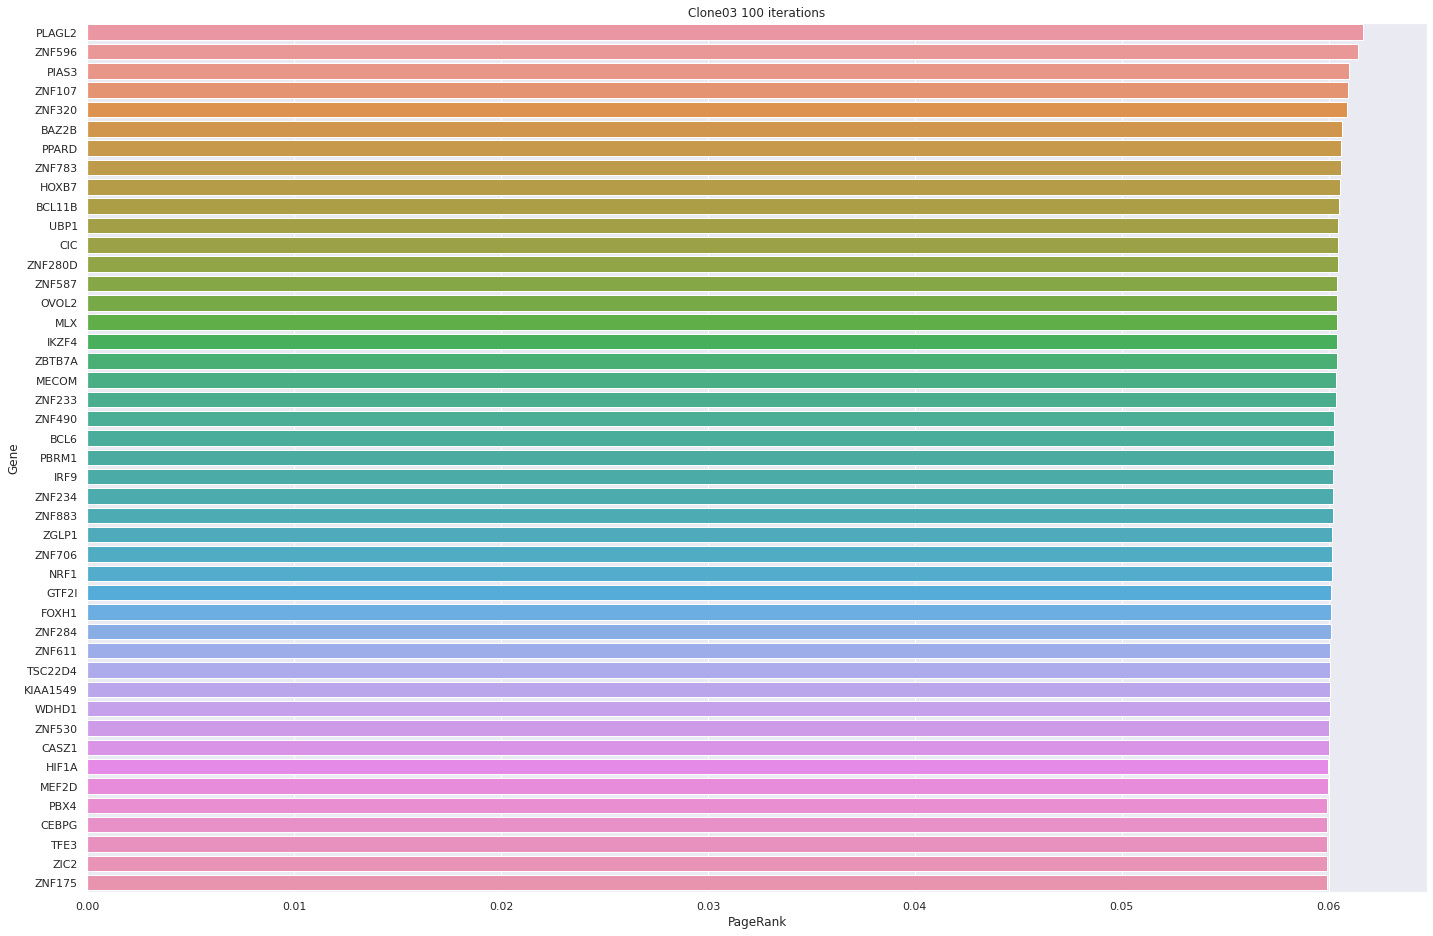

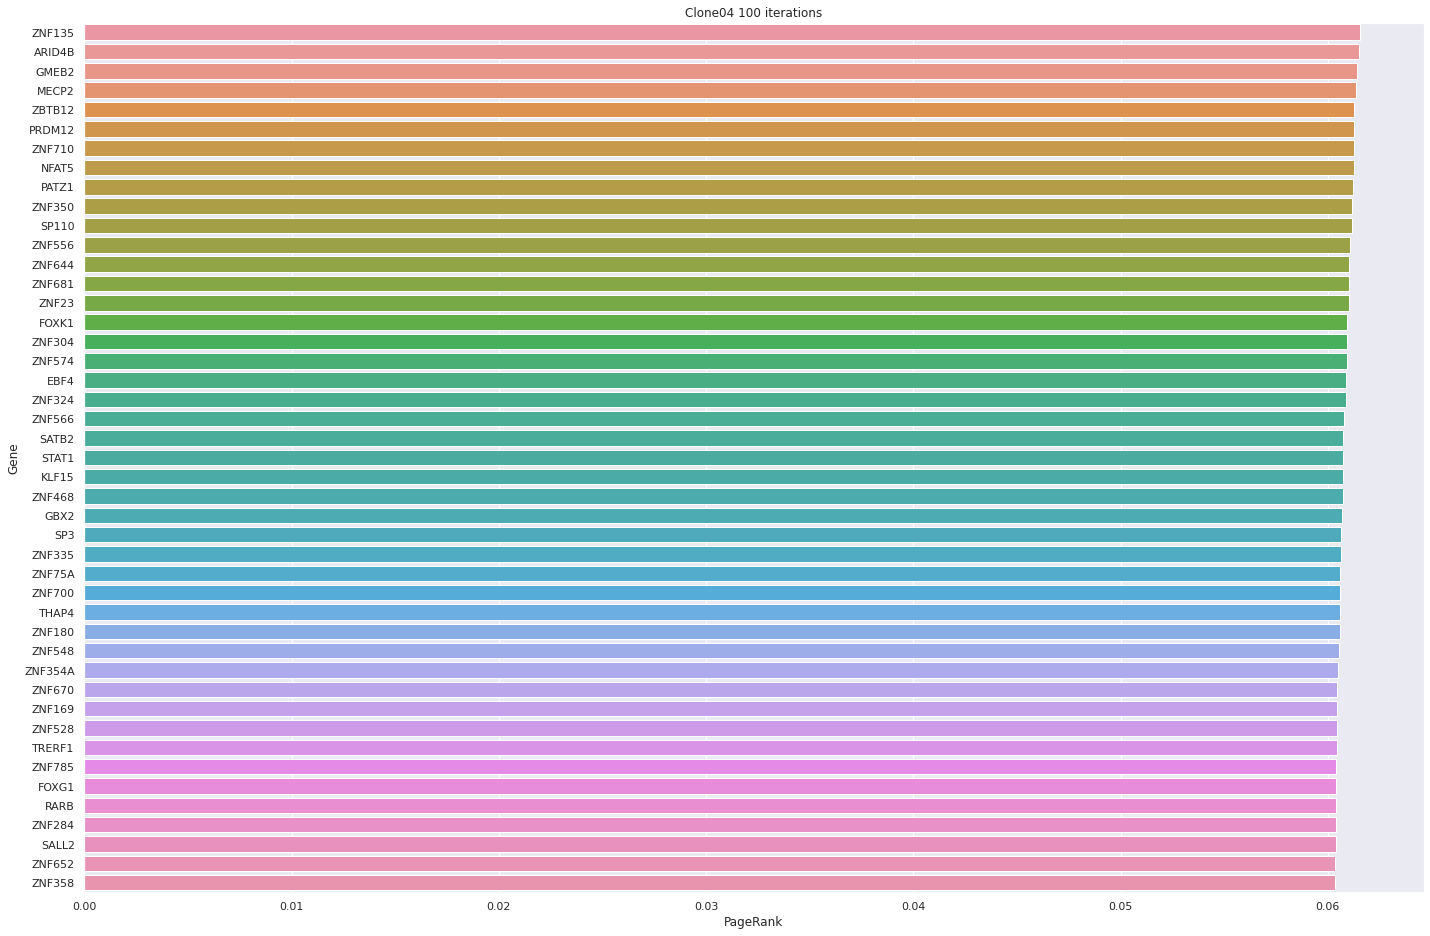

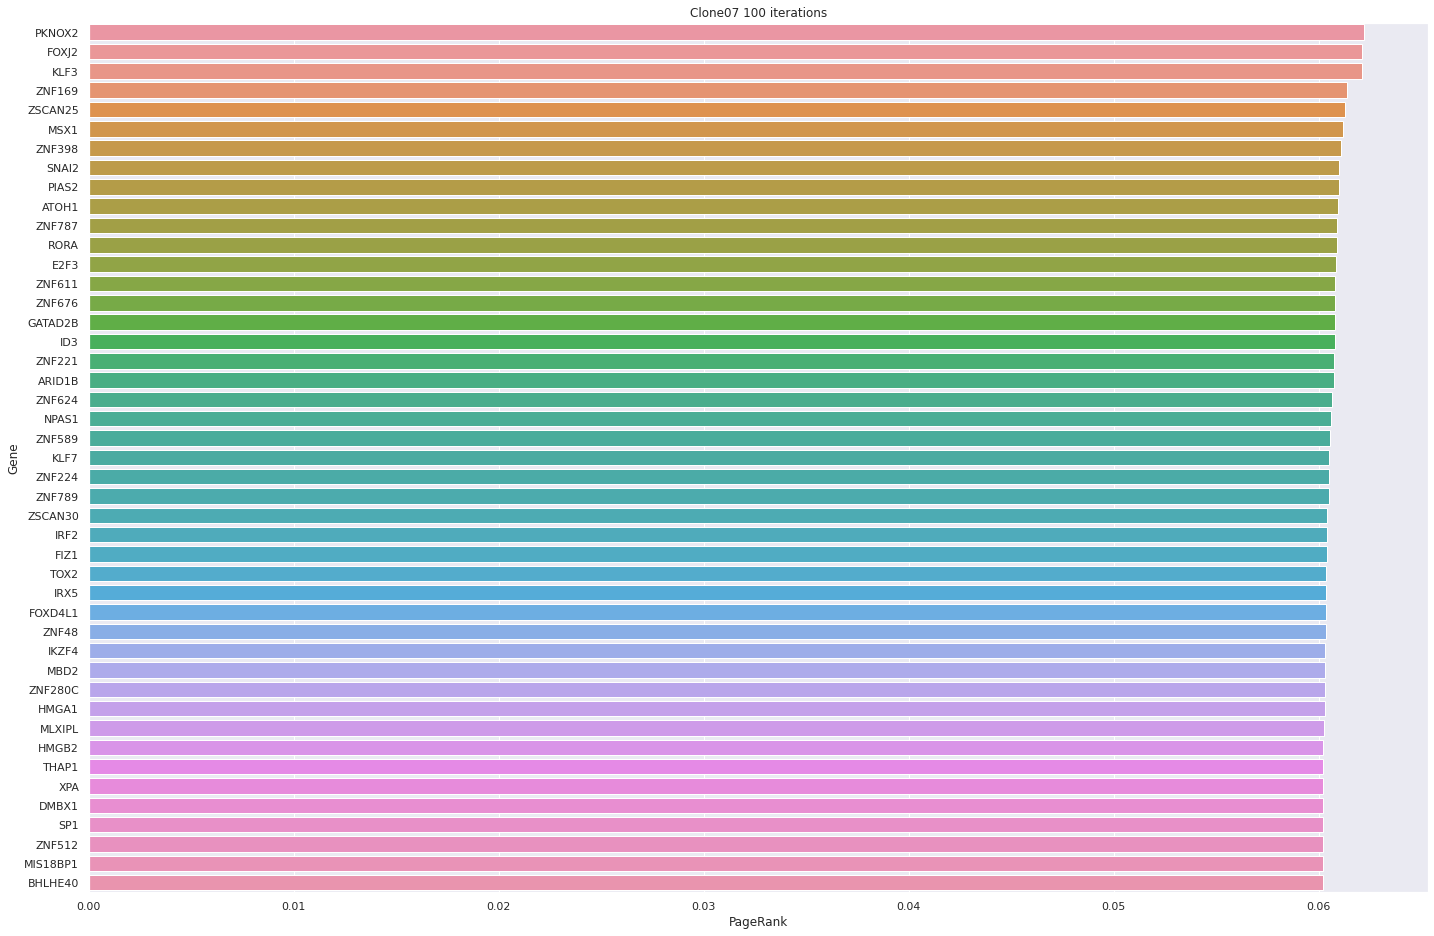

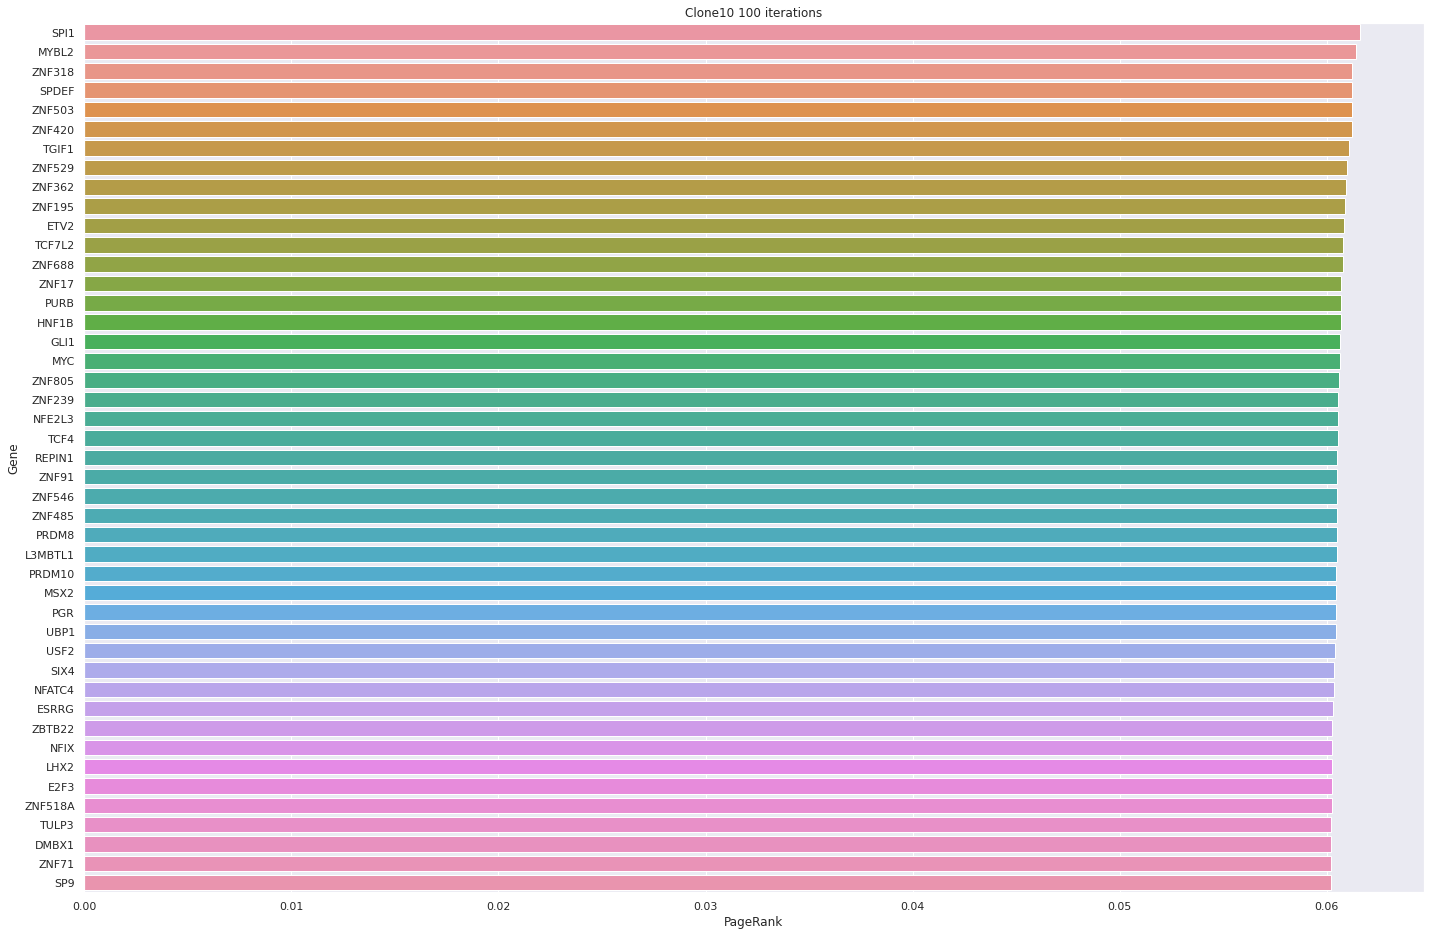

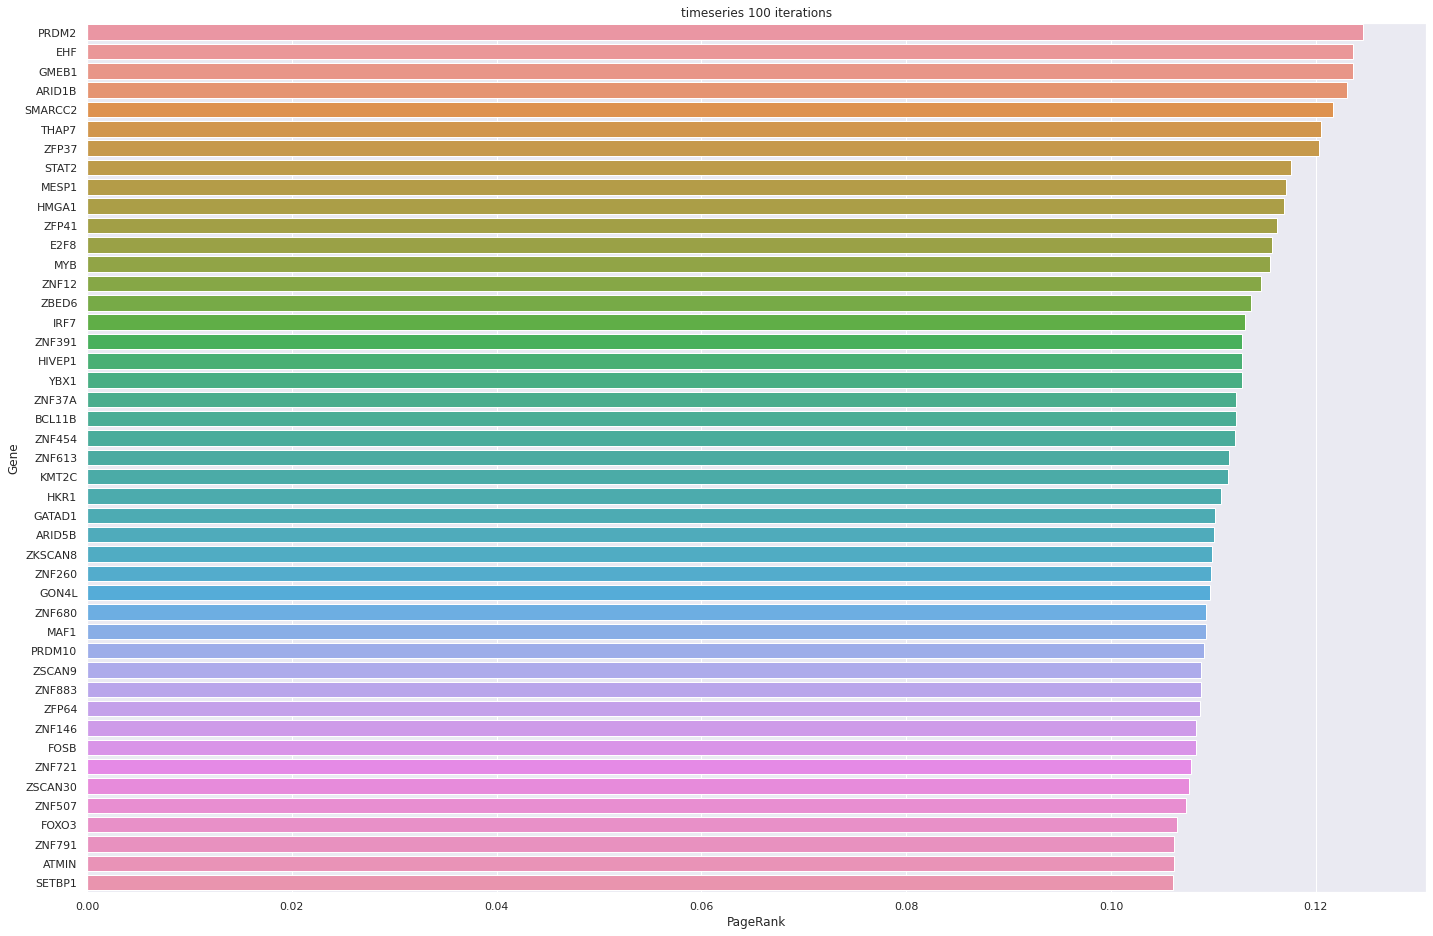

In [3]:
# Visualize aggregate data
wd = '/home/users/jvs15/MachineLearningProstate/STAMPScreen/grn_centrality'
names = ['Clone03.csv', 'Clone04.csv', 'Clone07.csv', 'Clone10.csv', 'timeseries.csv']
prdf_tot = [pd.read_csv(f'{wd}/aggregate_tfs_LNCaP_{i}') for i in names]

for i in range(len(prdf_tot)):
        sns.set(rc={'figure.figsize':(24,16)})
        sns.barplot(
            data=prdf_tot[i].sort_values('PageRank', ascending=False).head(45), 
            x='PageRank', 
            y='Gene'
        ).set(title=f'{names[i][0:len(names[i])-4]} 100 iterations')
        data=prdf_tot[i].sort_values('PageRank', ascending=False)
        #Save ranked TFs
        data.to_csv(f'aggregate_{names[i][0:len(names[i])-4]}_pageranked_tfs.csv')
        plt.show()

['ZNF33B', 'MAX', 'NFKB2', 'MESP1', 'ARID3B', 'SOX8', 'HES2', 'ZBTB39', 'ZNF688', 'DMRT2', 'ZNF419', 'ZNF777', 'NCOR1', 'ZNF251', 'RXRB', 'SP2', 'ZNF71', 'ZNF571', 'FOXO6', 'ZNF710', 'MEF2A', 'OSR2', 'GLI4', 'SP6', 'FOXO4', 'ZNF398', 'SIM2', 'TRERF1', 'NFATC1', 'ZNF19', 'ZFP41', 'TFAM', 'ZNF277', 'PIAS2', 'SOX12', 'ZNF821', 'ZNF256', 'DDIT3', 'ZNF672', 'TSC22D2', 'BARX2', 'TFAP2C', 'CASZ1', 'ZNF780A', 'ZNF732', 'MYSM1', 'ZNF66', 'RBAK', 'ZNF763', 'GATAD2B']


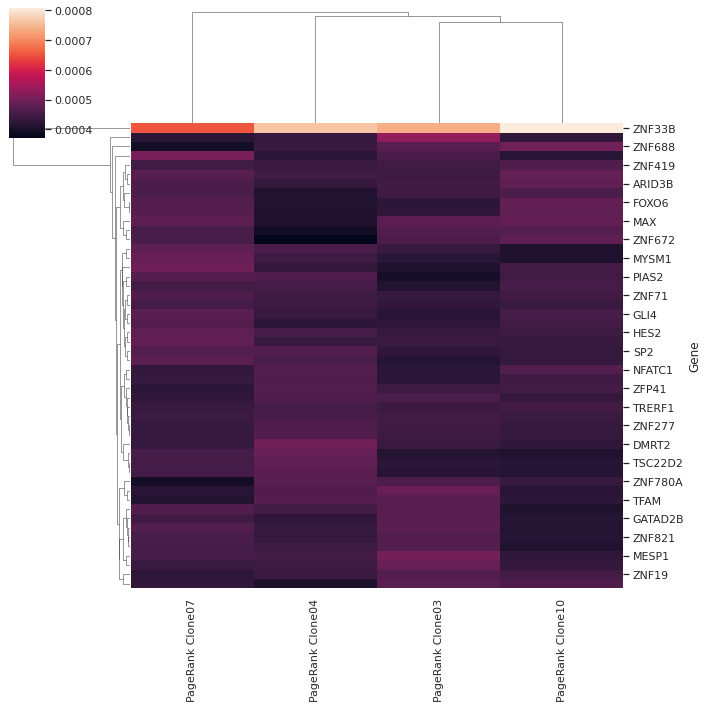

In [28]:
# Make a heatmap of aggregate pageranks

wd = '/home/users/jvs15/MachineLearningProstate/STAMPScreen/grn_centrality'
names = ['Clone03.csv', 'Clone04.csv', 'Clone07.csv', 'Clone10.csv', 'timeseries.csv']
prdf_tot = [pd.read_csv(f'{wd}/aggregate_tfs_LNCaP_{i}') for i in names]

newdf = pd.DataFrame()

for i in range(len(prdf_tot)):
    prdf_tot[i] = prdf_tot[i].drop('Unnamed: 0', axis=1)
    prdf_tot[i].set_index('Gene')
    prdf_tot[i].rename(columns={'PageRank':f'PageRank {names[i][0:len(names[i])-4]}'}, inplace=True)
    prdf_tot[i] = prdf_tot[i].set_index('Gene')
    if newdf.empty:
        newdf = prdf_tot[i]
    else:
        a = newdf
        newdf = pd.concat([a, prdf_tot[i]], axis=1)

# Sort dataframe by combined highest PageRank Score and then select only the top x rows of interest
x = 50
newdf = newdf.fillna(0)
newdf = newdf.drop(columns=['PageRank timeseries'])
newdf['Total Rank'] = newdf.sum(axis=1)
newdf = newdf.sort_values('Total Rank', ascending=False)
newdf = newdf.drop(['Total Rank'], axis=1)
g = sns.clustermap(newdf.iloc[:x])